In [85]:
%matplotlib inline
from simulation import *
from math import *
from cmath import exp, phase
import numpy as np
import os
import matplotlib.pyplot as plt


golden_root_dir = "~/repos/simulation/assets/ipynb/simulation/resource/golden_data_latest/near_field/hyper_lith_kirchhoff/case1"
aerial = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_aerial_binary.txt"), delimiter='\t')
near_field = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_mag_binary.txt"), delimiter='\t')
pupil = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_pupil_intensity_binary.txt"), delimiter='\t')

In [86]:
wavelength = 13.0
NA = 0.9
pitch = 16
cd = 8
dx = 1
size = int(ceil(pitch / dx))
center_y, center_x = size // 2, size // 2

grid_info_2d = grid_info_2d_s.create_grid_info_bloch_mode([size, size], wavelength, 0.0, NA, [[-pitch/2, -pitch/2], [pitch/2, pitch/2]], 1e-6)
print(grid_info_2d)

freq, _ = grid_info_2d.fourier.step


* grid info                           
----------------------------------------
tilesize      :  [16,16]              
spatial start :  [-8,-8]              
spatial step  :  [1,1]                
fourier start :  [0,0]                
fourier step  :  [0.902778,0.902778]  
coords place  :  |*--|corner          



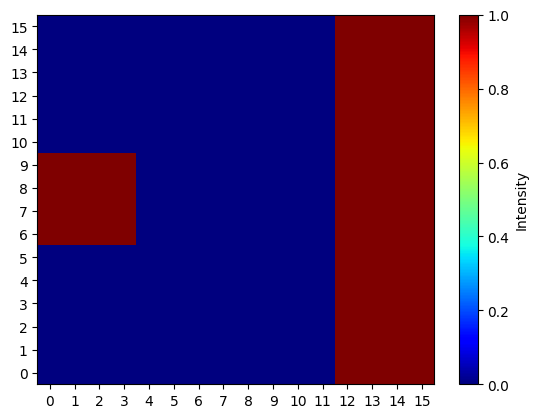

near field error = 0j


In [87]:
background = 1#polar_to_complex(0.86065, 0)
absorber = 0#polar_to_complex(0.0968, -2.675)
g2 = geo_manager([[
        [int(-cd/2/grid_info_2d.dbu), int(-cd/2/grid_info_2d.dbu)], 
        [int(-cd/2/grid_info_2d.dbu), int(cd/2/grid_info_2d.dbu)], 
        [int(cd/2/grid_info_2d.dbu), int(cd/2/grid_info_2d.dbu)], 
        [int(cd/2/grid_info_2d.dbu), int(-cd/2/grid_info_2d.dbu)]
    ]
])
g2 = geo_manager([[
        [int(-pitch/2/grid_info_2d.dbu), int(-pitch/8/grid_info_2d.dbu)], 
        [int(-pitch/2/grid_info_2d.dbu), int(pitch/8/grid_info_2d.dbu)], 
        [int(-pitch/4/grid_info_2d.dbu), int(pitch/8/grid_info_2d.dbu)], 
        [int(-pitch/4/grid_info_2d.dbu), int(-pitch/8/grid_info_2d.dbu)]
    ],[
        [int(pitch/4/grid_info_2d.dbu), int(-pitch/2/grid_info_2d.dbu)], 
        [int(pitch/4/grid_info_2d.dbu), int(pitch/2/grid_info_2d.dbu)], 
        [int(pitch/2/grid_info_2d.dbu), int(pitch/2/grid_info_2d.dbu)], 
        [int(pitch/2/grid_info_2d.dbu), int(-pitch/2/grid_info_2d.dbu)]
    ],

])
mask = binary_mask.create(absorber, background, grid_info_2d, g2.get_vertex())
grid_info_2d.display(mask)
complex_data_array = np.array(mask, dtype=np.complex64).reshape((size, size))
print(f"near field error = {np.max(complex_data_array - near_field)}")

In [88]:
fourier_shifted = np.fft.fftshift(np.fft.fft2(complex_data_array))

difract = diffraction(grid_info_2d)
print(difract.update_diffraction_source_points(fourier_shifted.flatten().tolist()))
pupil_intensity = difract.get_imaging_pupil_intensity([100, 100])

amp_error = [a - x for a, x in zip(pupil.flatten().tolist(), pupil_intensity)]
assert(max(np.abs(amp_error)) < grid_info_2d.dbu)

#  Sigma-X    Sigma-Y    Intensity   E-field-direction  DOP  Ellipticity  
---------------------------------------------------------------------------------
0  0          -0.902778  0.00320729  2.50448e-06        0    0            
1  -0.902778  0          0.054524    270                0    0            
2  0          0          0.0976562   90                 0    0            
3  0.902778   0          0.054524    90                 0    0            
4  0          0.902778   0.00320729  180                0    0            



In [89]:
def shift_phase(ix, iy, N, delta_x=0.5, delta_y=0.5):
    return np.exp(-2j * np.pi * (ix * delta_x / N + iy * delta_y / N))

desired_orders = get_diffraction_order(grid_info_2d)
print(f"保留的衍射级次: {desired_orders}")

# TE = np.zeros_like(fourier_shifted)
TE = np.zeros((40, 40), dtype=np.complex64)
TM = np.zeros_like(TE)

保留的衍射级次: [[0,-1],[-1,0],[0,0],[1,0],[0,1]]


In [90]:
def create_rotation_matrix(incident_angle_deg, azimuthal_angle_deg):
    """
    根据入射角和方位角创建旋转矩阵。

    该函数将一个沿正z轴的矢量旋转到由入射角和方位角定义的新方向。
    旋转顺序为：首先绕y轴旋转入射角，然后绕z轴旋转方位角。

    参数:
    - incident_angle_deg (float): 入射角，单位为度（与z轴的夹角）。
    - azimuthal_angle_deg (float): 方位角，单位为度（在xy平面投影与x轴的夹角）。

    返回:
    - numpy.ndarray: 3x3 的旋转矩阵。
    """
    # 将角度从度转换为弧度
    theta = incident_angle_deg
    phi = azimuthal_angle_deg
    
    # 绕y轴旋转theta的矩阵
    Ry = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    
    # 绕z轴旋转phi的矩阵
    Rz = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])
    
    # 组合旋转矩阵 (Rz * Ry)
    rotation_matrix = Rz @ Ry
    
    return rotation_matrix

def reconstruct_intensity_from_diffract(diffract):
    ifft = np.fft.ifft2(np.fft.ifftshift(diffract))
    return np.real(ifft * np.conj(ifft))
def test3():
    def projection(is_TE, fft_coef: complex, ix = 0, iy=0):
        fx, fy = freq*ix, freq * iy

        inc_angle = asin(hypot(fx, fy))
        azimuth = -atan2(fy, fx)
        # print(f"inc_angle={inc_angle * 180/pi}, azimuth={azimuth* 180/pi}")

        vec = np.array([fft_coef, fft_coef, 0])
        init_dir = np.array([[1, 0, 0], [0, 1, 0]][int(is_TE)])
        R = create_rotation_matrix(inc_angle, azimuth)
        polar_dir = R @ init_dir
        print(f"x,y={ix},{iy}, is_TE={["NO", "YES"][int(is_TE)]}, polar_dir={polar_dir}")

        # S * TM + P * TE
        return np.dot(vec, np.sqrt(np.abs(polar_dir)))
    for order_x, order_y in desired_orders:
        posy, posx = TE.shape[0]//2 + order_y, TE.shape[1]//2 + order_x
        fft_coef = fourier_shifted[center_y + order_y, center_x + order_x]
        TE[posy, posx] = projection(True, fft_coef, order_x, order_y )
        TM[posy, posx] = projection(False, fft_coef, order_x, order_y )

    reconstructed_data_TE = reconstruct_intensity_from_diffract(TE)
    reconstructed_data_TM = reconstruct_intensity_from_diffract(TM)
    reconstructed_data_TE += reconstructed_data_TM
    reconstructed_data_TM = np.zeros(reconstructed_data_TM.shape)
    return reconstructed_data_TE, reconstructed_data_TM
    
def safe_divide(a, b):
    return np.nan_to_num(np.divide(a, b), nan=0.0, posinf=0.0, neginf=0.0)
def test4():
    def projection(is_TE, fft_coef: complex, ix = 0, iy=0):
        fx, fy = freq*ix, freq * iy
        inc_angle = asin(hypot(fx, fy))
        azimuth = -atan2(fy, fx)
        # print(f"inc_angle={inc_angle * 180/pi}, azimuth={azimuth* 180/pi}")
        
        def obliquity_factor():
            return 0.5 *(1 + cos(inc_angle))
        fft_coef = fft_coef * obliquity_factor()
        
        vec = [np.array([fft_coef, 0, 0]), np.array([0, fft_coef, 0])][int(is_TE)]
        R = create_rotation_matrix(inc_angle, azimuth)
        TM_dir = R @ np.array([1, 0, 0])
        TE_dir = R @ np.array([0, 1, 0])
        print(f"x,y={ix},{iy}, is_TE={["NO", "YES"][int(is_TE)]}, polar_dir={TM_dir}, {TE_dir}")
        # init_dir = init_dir / np.sqrt(np.abs(polar_dir))
        # return [fft_coef*TM_dir, fft_coef * TE_dir][int(is_TE)]
        # return np.dot(vec,  safe_divide(TE_dir, np.sqrt(np.abs(TE_dir)))), np.dot(vec, safe_divide(TM_dir, np.sqrt(np.abs(TM_dir)))), 0
        return np.dot(vec,  np.sqrt(np.abs(TE_dir))) , np.dot(vec, np.sqrt(np.abs(TM_dir))), 0
        return np.dot(vec,  safe_divide(TE_dir, np.sqrt(np.abs(TE_dir)))), np.dot(vec, safe_divide(TM_dir, np.sqrt(np.abs(TM_dir)))), 0
    
    TE_x = TE
    TE_y = np.zeros_like(TE)
    TE_z = np.zeros_like(TE)
    TM_x = TM
    TM_y = np.zeros_like(TM)
    TM_z = np.zeros_like(TM)
    for order_x, order_y in desired_orders:
        posy, posx = TE.shape[0]//2 + order_y, TE.shape[1]//2 + order_x
        fft_coef = fourier_shifted[center_y + order_y, center_x + order_x]
        TE_x[posy, posx], TE_y[posy, posx], TE_z[posy, posx] = projection(True, fft_coef, order_x, order_y ) 
        TM_x[posy, posx], TM_y[posy, posx], TM_z[posy, posx] = projection(False, fft_coef, order_x, order_y )

    TE_x += TE_y
    TE_y = np.zeros(TE_y.shape)
    TM_x += TM_y
    TM_y = np.zeros(TE_y.shape)
    reconstructed_data_TE = reconstruct_intensity_from_diffract(TE_x) + reconstruct_intensity_from_diffract(TE_y)
    reconstructed_data_TM = reconstruct_intensity_from_diffract(TM_x) + reconstruct_intensity_from_diffract(TM_y)

    
    return reconstructed_data_TE, reconstructed_data_TM

reconstructed_data_TE, reconstructed_data_TM = test4()


x,y=0,-1, is_TE=YES, polar_dir=[ 2.63364743e-17  4.30107266e-01 -9.02777791e-01], [-1.000000e+00  6.123234e-17  0.000000e+00]
x,y=0,-1, is_TE=NO, polar_dir=[ 2.63364743e-17  4.30107266e-01 -9.02777791e-01], [-1.000000e+00  6.123234e-17  0.000000e+00]
x,y=-1,0, is_TE=YES, polar_dir=[-4.30107266e-01 -5.26729486e-17 -9.02777791e-01], [ 1.2246468e-16 -1.0000000e+00  0.0000000e+00]
x,y=-1,0, is_TE=NO, polar_dir=[-4.30107266e-01 -5.26729486e-17 -9.02777791e-01], [ 1.2246468e-16 -1.0000000e+00  0.0000000e+00]
x,y=0,0, is_TE=YES, polar_dir=[1. 0. 0.], [0. 1. 0.]
x,y=0,0, is_TE=NO, polar_dir=[1. 0. 0.], [0. 1. 0.]
x,y=1,0, is_TE=YES, polar_dir=[ 0.43010727  0.         -0.90277779], [0. 1. 0.]
x,y=1,0, is_TE=NO, polar_dir=[ 0.43010727  0.         -0.90277779], [0. 1. 0.]
x,y=0,1, is_TE=YES, polar_dir=[ 2.63364743e-17 -4.30107266e-01 -9.02777791e-01], [1.000000e+00 6.123234e-17 0.000000e+00]
x,y=0,1, is_TE=NO, polar_dir=[ 2.63364743e-17 -4.30107266e-01 -9.02777791e-01], [1.000000e+00 6.123234e-17

In [91]:

reconstructed_data_TE_1 = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_aerial_binary_TE.txt"), delimiter='\t')

reconstructed_data_TM_1 = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_aerial_binary_TM.txt"), delimiter='\t')

reconstructed_data_magnitude = (reconstructed_data_TE + reconstructed_data_TM) / 2


In [92]:
def plotnx1(im_list, name_list, n = 4):
    fig, axes = plt.subplots(1, n, figsize=(12, 6))
    def sub_plot(n, data, name):
        fig.colorbar(axes[n].imshow(data, cmap='viridis'), ax=axes[n], label='')
        axes[n].set_title(name)
        axes[n].axis('off')
    for i in range(n):
        sub_plot(i, im_list[i], name_list[i])
    plt.tight_layout() 
    plt.show()
    print(f"max {name_list[-1]}={np.max(im_list[-1])}")
def normlization(golden, input):
    return input * np.max(golden)/np.max(input)
def normlization_diff(golden, input):
    return np.abs(golden - normlization(golden, input)) / 1

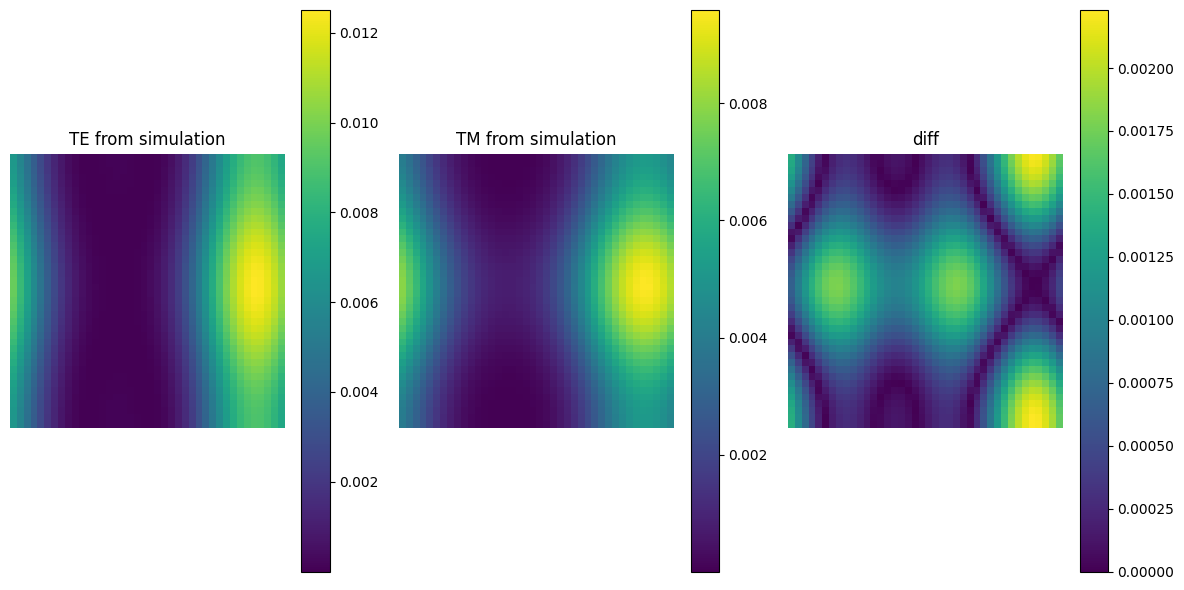

max diff=0.0022306196315823503


In [93]:
plotnx1([reconstructed_data_TE, reconstructed_data_TM, normlization_diff(reconstructed_data_TE, reconstructed_data_TM)], 
        ["TE from simulation", "TM from simulation", "diff"], 3
)

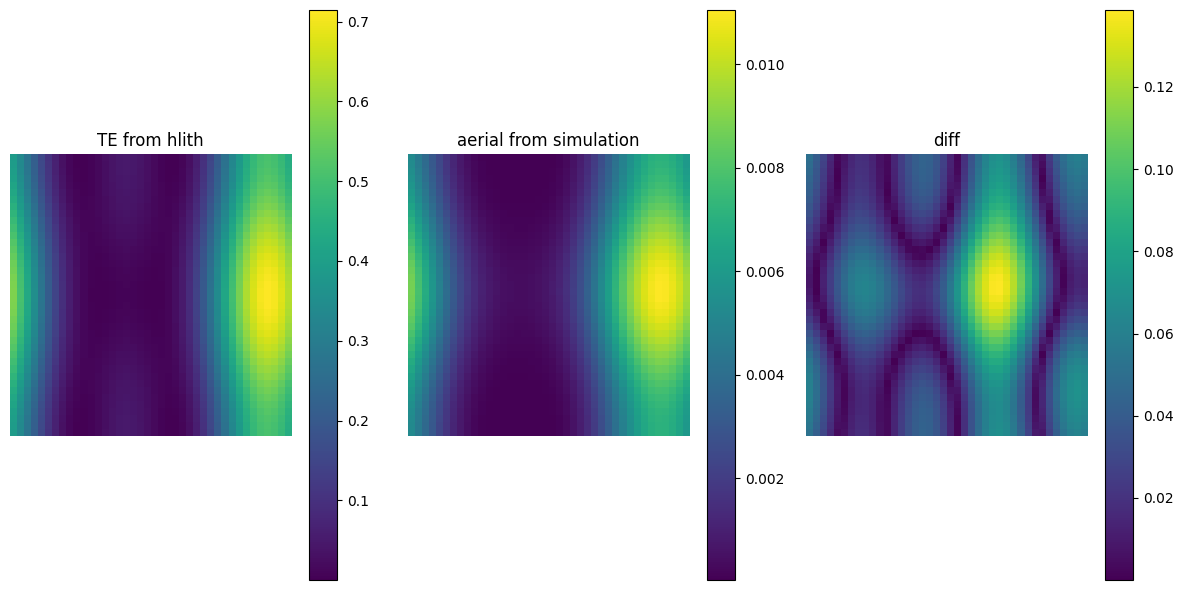

max diff=0.1387292067270552
5.6292447e-05, 0.7146063


In [94]:
plotnx1([reconstructed_data_TE_1, reconstructed_data_magnitude, normlization_diff(reconstructed_data_TE_1, reconstructed_data_magnitude)], 
        ["TE from hlith", "aerial from simulation", "diff"], 3
)
print(f"{np.min(reconstructed_data_TE_1)}, {np.max(reconstructed_data_TE_1)}")

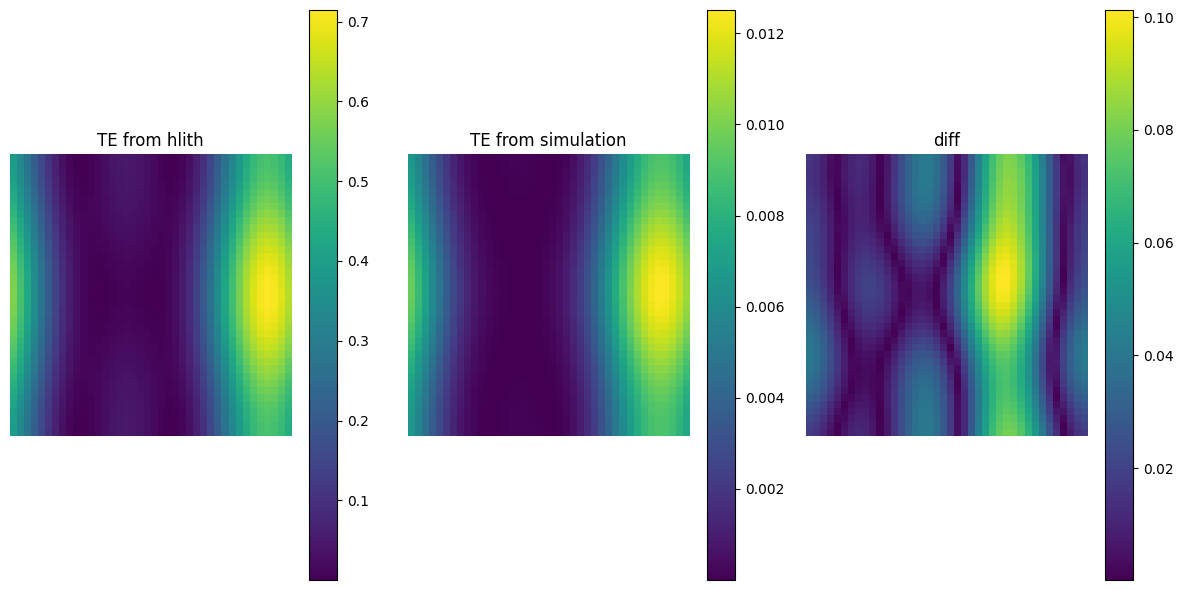

max diff=0.10129032180136432


In [95]:
plotnx1([reconstructed_data_TE_1, reconstructed_data_TE, normlization_diff(reconstructed_data_TE_1, reconstructed_data_TE)], 
        ["TE from hlith", "TE from simulation", "diff"], 3
)

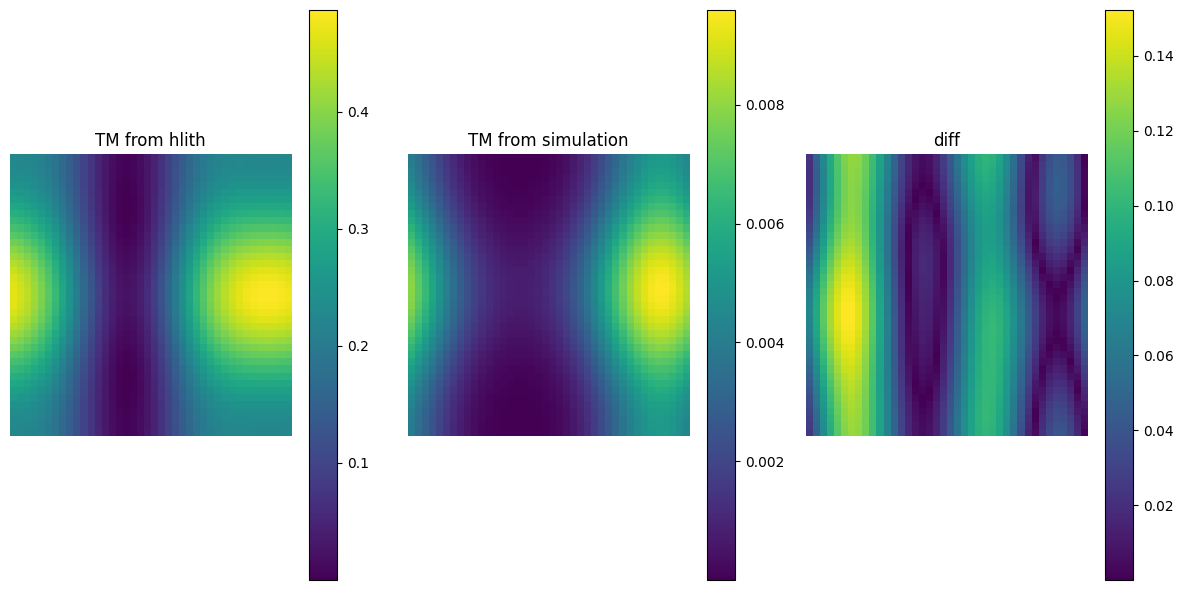

max diff=0.15228705133609682


In [96]:
plotnx1([reconstructed_data_TM_1, reconstructed_data_TM, normlization_diff(reconstructed_data_TM_1, reconstructed_data_TM)], 
        ["TM from hlith", "TM from simulation", "diff"], 3
)

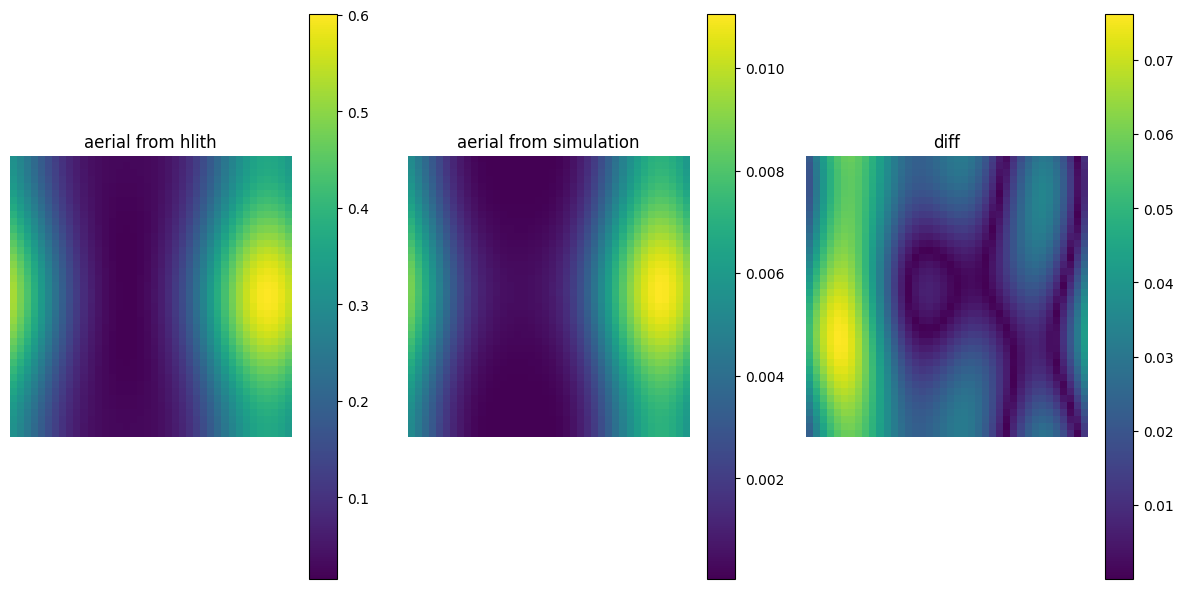

max diff=0.07617405781968789


In [97]:
plotnx1([aerial, reconstructed_data_magnitude, normlization_diff(aerial, reconstructed_data_magnitude)], 
        ["aerial from hlith", "aerial from simulation", "diff"], 3
)

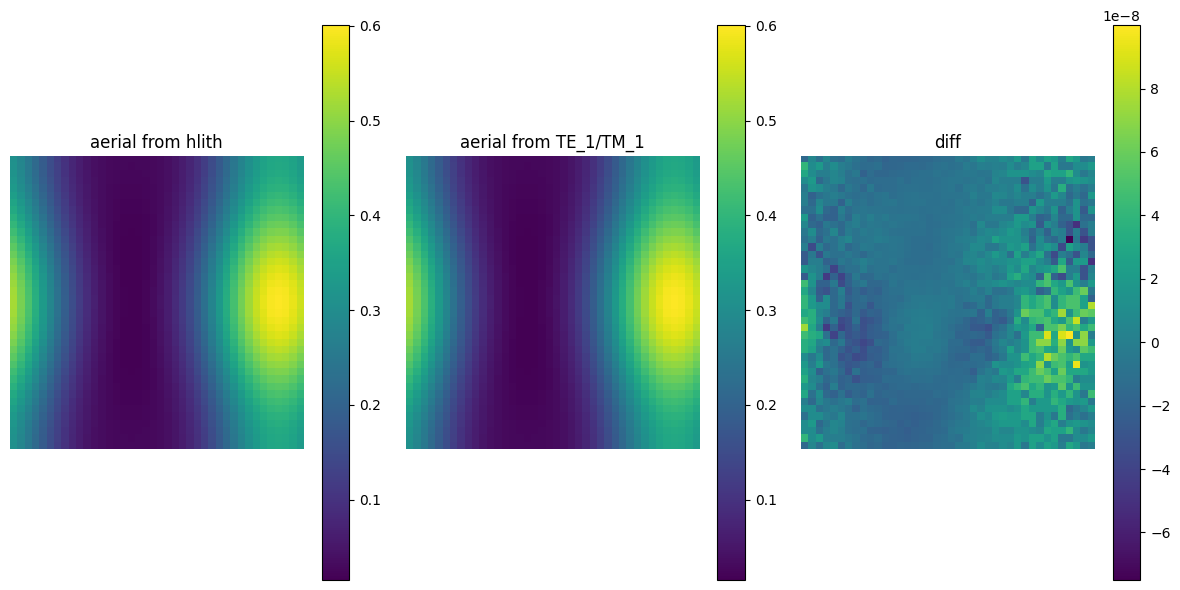

max diff=9.999999994736442e-08


In [98]:
reconstructed_data_magnitude_1 = (reconstructed_data_TE_1 + reconstructed_data_TM_1) / 2
plotnx1([aerial, reconstructed_data_magnitude_1, reconstructed_data_magnitude_1 - aerial], 
        ["aerial from hlith", "aerial from TE_1/TM_1", "diff"], 3
)